In [1]:
import sys
# This forces pip to install into the exact python kernel currently running
!{sys.executable} -m pip install diffusers transformers accelerate safetensors datasets


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [2]:
import sys
!{sys.executable} -m pip install peft


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [15]:
import torch
from diffusers import StableDiffusionInstructPix2PixPipeline
from PIL import Image
from datasets import load_from_disk
import matplotlib.pyplot as plt
import os

# Suppress warnings for a cleaner output
import warnings
warnings.filterwarnings("ignore")

# Define paths - UPDATED FOR YOUR SYSTEM
LORA_PATH = "/Users/szening/Project/pytorch_lora_weights.safetensors"  # LoRA weights in same folder as notebook
BASE_MODEL_ID = "timbrooks/instruct-pix2pix"  # Base model
DATASET_PATH = "/Users/szening/Project/interior_design_split"  # Your dataset path (update if needed)

print("Setup complete.")
print(f"LoRA weights path: {LORA_PATH}")
print(f"LoRA weights exist: {os.path.exists(LORA_PATH)}")

Setup complete.
LoRA weights path: /Users/szening/Project/pytorch_lora_weights.safetensors
LoRA weights exist: True


In [16]:
print("⏳ Loading base model...")
pipe = StableDiffusionInstructPix2PixPipeline.from_pretrained(
    BASE_MODEL_ID,
    torch_dtype=torch.float16,
    safety_checker=None 
)

print(f"⏳ Loading LoRA weights from {LORA_PATH}...")
try:
    pipe.load_lora_weights(LORA_PATH)
    print("LoRA weights loaded successfully.")
except Exception as e:
    print(f"Error loading LoRA: {e}")
    print("Running with Base Model only.")

# Move to Mac GPU
pipe.to("mps")
print("Model is ready on Metal (MPS)!")

⏳ Loading base model...


Loading pipeline components...: 100%|██████████| 6/6 [00:03<00:00,  1.85it/s]
No LoRA keys associated to CLIPTextModel found with the prefix='text_encoder'. This is safe to ignore if LoRA state dict didn't originally have any CLIPTextModel related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diffusers/issues/new


⏳ Loading LoRA weights from /Users/szening/Project/pytorch_lora_weights.safetensors...
LoRA weights loaded successfully.
Model is ready on Metal (MPS)!


In [17]:
def visualize_edit(original, edited, instruction):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    
    # Left: Original
    ax[0].imshow(original)
    ax[0].set_title("Original Room", fontsize=14)
    ax[0].axis("off")
    
    # Right: Result
    ax[1].imshow(edited)
    ax[1].set_title("AI Redesign", fontsize=14)
    ax[1].axis("off")
    
    # Title: The Instruction
    plt.suptitle(f'"{instruction}"', fontsize=16, y=0.95)
    plt.tight_layout()
    plt.show()

print("✅ Visualization helper ready.")

✅ Visualization helper ready.


🎨 Generating: 'Replace the curtains with wooden blinds.'...


100%|██████████| 200/200 [03:34<00:00,  1.07s/it]


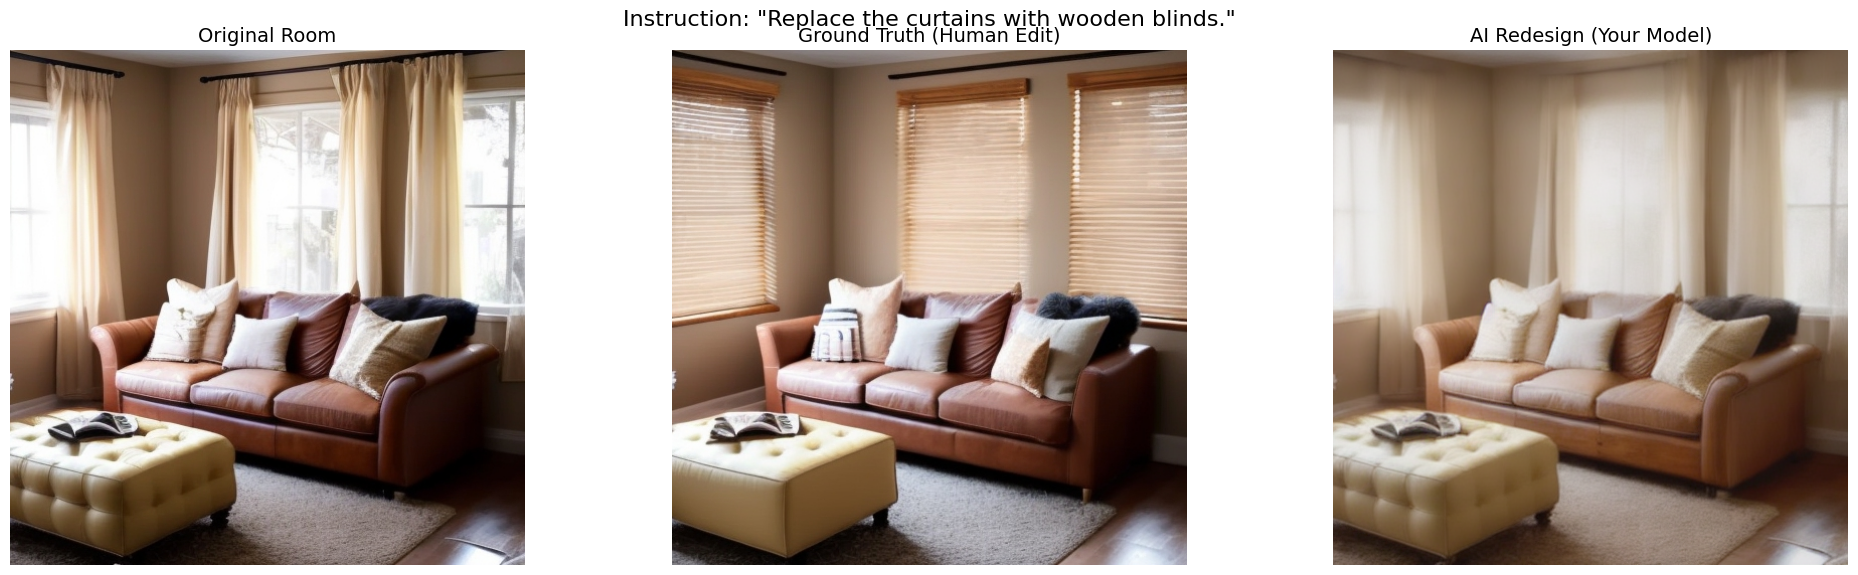

In [18]:
import matplotlib.pyplot as plt

def visualize_comparison(original, target, generated, instruction):
    fig, ax = plt.subplots(1, 3, figsize=(20, 6))
    
    # 1. Original Image
    ax[0].imshow(original)
    ax[0].set_title("Original Room", fontsize=14)
    ax[0].axis("off")

    # 2. Ground Truth (Target from Dataset)
    ax[1].imshow(target)
    ax[1].set_title("Ground Truth (Human Edit)", fontsize=14)
    ax[1].axis("off")
    
    # 3. AI Prediction (Your Model)
    ax[2].imshow(generated)
    ax[2].set_title("AI Redesign (Your Model)", fontsize=14)
    ax[2].axis("off")
    
    # Title
    plt.suptitle(f'Instruction: "{instruction}"', fontsize=16, y=0.95)
    plt.tight_layout()
    plt.show()

# --- RUN TEST ---
import random

# 1. Pick a random example
index = random.randint(0, len(test_data) - 1)
sample = test_data[index]

# 2. Extract Data
original_image = sample["original_image"]
target_image = sample["designed_image"] # This is the "correct" answer
prompt = sample["edit_prompt"]

# Resize for consistency/speed
original_image = original_image.resize((512, 512))
target_image = target_image.resize((512, 512))

print(f"🎨 Generating: '{prompt}'...")

# 3. Generate with your Model
result_image = pipe(
    prompt,
    image=original_image,
    num_inference_steps=200,
    image_guidance_scale=1.5,
    guidance_scale=7.5
).images[0]

# 4. Compare all three
visualize_comparison(original_image, target_image, result_image, prompt)

In [10]:
if os.path.exists(DATASET_PATH):
    dataset = load_from_disk(DATASET_PATH)
    test_data = dataset["test"]
    print(f"Loaded test dataset with {len(test_data)} examples.")
else:
    print("⚠️ Dataset not found. You will need to provide your own images.")
    test_data = []

Loaded test dataset with 852 examples.


Generating: 'Change the metal frame to a wooden frame.'...


100%|██████████| 100/100 [01:48<00:00,  1.08s/it]


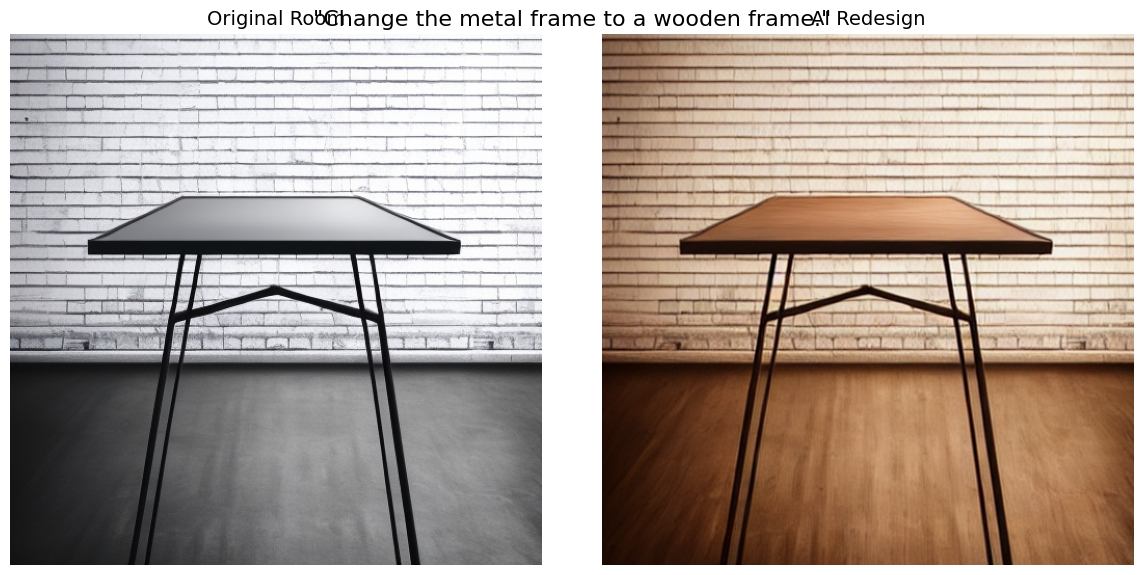

In [19]:
# --- OPTION A: Pick a random image from your test set ---
import random
index = random.randint(0, len(test_data) - 1)
sample = test_data[index]

original_image = sample["original_image"]
prompt = sample["edit_prompt"]

# --- OPTION B: Use your own custom image (Uncomment to use) ---
# original_image = Image.open("path/to/my_living_room.jpg").convert("RGB")
# prompt = "Replace the sofa with a modern white sectional"

# Resize for speed/consistency
original_image = original_image.resize((512, 512))

print(f"Generating: '{prompt}'...")

# Generate
result_image = pipe(
    prompt,
    image=original_image,
    num_inference_steps=100,       # Higher = Better quality, Slower
    image_guidance_scale=1.5,     # Keep at 1.5
    guidance_scale=7.5            # Keep at 7.5
).images[0]

# Display
visualize_edit(original_image, result_image, prompt)

In [20]:
import json
from datetime import datetime
from tqdm import tqdm

# Configuration
NUM_SAMPLES = 100  # Test on 100 images
NUM_INFERENCE_STEPS = 50  # Reduced from 100 for speed
OUTPUT_DIR = "/Users/szening/Project/evaluation_results"

# Create output directory
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(f"{OUTPUT_DIR}/images", exist_ok=True)

# Storage for results
results = []

print(f"🚀 Starting evaluation on {NUM_SAMPLES} images...")
print(f"⏱️ Estimated time: ~{NUM_SAMPLES * 0.9:.1f} minutes ({NUM_SAMPLES * 0.9 / 60:.1f} hours)")
print(f"📁 Saving results to: {OUTPUT_DIR}\n")

# Process images
for i in tqdm(range(NUM_SAMPLES), desc="Processing images"):
    sample = test_data[i]
    
    # Get data
    original_image = sample["original_image"].resize((512, 512))
    target_image = sample["designed_image"].resize((512, 512))
    prompt = sample["edit_prompt"]
    
    # Generate with model
    result_image = pipe(
        prompt,
        image=original_image,
        num_inference_steps=NUM_INFERENCE_STEPS,
        image_guidance_scale=1.5,
        guidance_scale=7.5
    ).images[0]
    
    # Save images
    original_image.save(f"{OUTPUT_DIR}/images/{i:04d}_original.png")
    target_image.save(f"{OUTPUT_DIR}/images/{i:04d}_target.png")
    result_image.save(f"{OUTPUT_DIR}/images/{i:04d}_generated.png")
    
    # Store metadata
    results.append({
        "index": i,
        "prompt": prompt,
        "original_path": f"images/{i:04d}_original.png",
        "target_path": f"images/{i:04d}_target.png",
        "generated_path": f"images/{i:04d}_generated.png"
    })

# Save results metadata
with open(f"{OUTPUT_DIR}/results.json", "w") as f:
    json.dump(results, f, indent=2)

print(f"\n✅ Evaluation complete!")
print(f"📊 Processed {NUM_SAMPLES} images")
print(f"💾 Results saved to: {OUTPUT_DIR}")
print(f"📄 Metadata saved to: {OUTPUT_DIR}/results.json")

🚀 Starting evaluation on 100 images...
⏱️ Estimated time: ~90.0 minutes (1.5 hours)
📁 Saving results to: /Users/szening/Project/evaluation_results



100%|██████████| 50/50 [00:56<00:00,  1.13s/it]0<?, ?it/s]

100%|██████████| 50/50 [00:53<00:00,  1.07s/it]7<1:35:32, 57.90s/it]

100%|██████████| 50/50 [00:55<00:00,  1.11s/it]2<1:31:45, 56.18s/it]

100%|██████████| 50/50 [00:54<00:00,  1.10s/it]9<1:31:26, 56.56s/it]

100%|██████████| 50/50 [00:54<00:00,  1.08s/it]6<1:30:17, 56.43s/it]

100%|██████████| 50/50 [00:54<00:00,  1.09s/it]1<1:28:46, 56.07s/it]

100%|██████████| 50/50 [00:54<00:00,  1.08s/it]7<1:27:35, 55.91s/it]

100%|██████████| 50/50 [00:54<00:00,  1.08s/it]2<1:26:21, 55.71s/it]

100%|██████████| 50/50 [00:55<00:00,  1.11s/it]7<1:25:18, 55.64s/it]

100%|██████████| 50/50 [00:55<00:00,  1.10s/it]4<1:24:56, 56.01s/it]

100%|██████████| 50/50 [00:55<00:00,  1.11s/it]21<1:24:16, 56.18s/it]

100%|██████████| 50/50 [00:55<00:00,  1.12s/it]18<1:23:40, 56.41s/it]

100%|██████████| 50/50 [00:54<00:00,  1.09s/it]15<1:23:05, 56.65s/it]

100%|██████████| 50/50 [00:53<00:00,  1.08s/it]11<1:21:42, 56.35s/it]

100%|██████████| 50/50 [00


✅ Evaluation complete!
📊 Processed 100 images
💾 Results saved to: /Users/szening/Project/evaluation_results
📄 Metadata saved to: /Users/szening/Project/evaluation_results/results.json


# Baseline Evaluation (Base Model Only)

Now we'll run the same evaluation with the **base model without LoRA weights** to establish a baseline for comparison.

In [21]:
print("⏳ Loading base model (NO LoRA)...")
base_pipe = StableDiffusionInstructPix2PixPipeline.from_pretrained(
    BASE_MODEL_ID,
    torch_dtype=torch.float16,
    safety_checker=None 
)

# Move to Mac GPU (NO LoRA weights loaded)
base_pipe.to("mps")
print("✅ Base model ready (without fine-tuning)!")

⏳ Loading base model (NO LoRA)...


Loading pipeline components...: 100%|██████████| 6/6 [00:03<00:00,  1.64it/s]



✅ Base model ready (without fine-tuning)!


In [22]:
import json
from datetime import datetime
from tqdm import tqdm

# Configuration
NUM_SAMPLES = 100  # Test on 100 images
NUM_INFERENCE_STEPS = 50  # Same as fine-tuned model
OUTPUT_DIR_BASE = "/Users/szening/Project/evaluation_results_baseline"

# Create output directory
os.makedirs(OUTPUT_DIR_BASE, exist_ok=True)
os.makedirs(f"{OUTPUT_DIR_BASE}/images", exist_ok=True)

# Storage for results
results_base = []

print(f"🚀 Starting baseline evaluation on {NUM_SAMPLES} images...")
print(f"⏱️ Estimated time: ~{NUM_SAMPLES * 0.9:.1f} minutes ({NUM_SAMPLES * 0.9 / 60:.1f} hours)")
print(f"📁 Saving results to: {OUTPUT_DIR_BASE}\n")

# Process the SAME images as the fine-tuned model
for i in tqdm(range(NUM_SAMPLES), desc="Processing images (baseline)"):
    sample = test_data[i]
    
    # Get data
    original_image = sample["original_image"].resize((512, 512))
    target_image = sample["designed_image"].resize((512, 512))
    prompt = sample["edit_prompt"]
    
    # Generate with BASE model (no LoRA)
    result_image = base_pipe(
        prompt,
        image=original_image,
        num_inference_steps=NUM_INFERENCE_STEPS,
        image_guidance_scale=1.5,
        guidance_scale=7.5
    ).images[0]
    
    # Save images
    original_image.save(f"{OUTPUT_DIR_BASE}/images/{i:04d}_original.png")
    target_image.save(f"{OUTPUT_DIR_BASE}/images/{i:04d}_target.png")
    result_image.save(f"{OUTPUT_DIR_BASE}/images/{i:04d}_generated.png")
    
    # Store metadata
    results_base.append({
        "index": i,
        "prompt": prompt,
        "original_path": f"images/{i:04d}_original.png",
        "target_path": f"images/{i:04d}_target.png",
        "generated_path": f"images/{i:04d}_generated.png"
    })

# Save results metadata
with open(f"{OUTPUT_DIR_BASE}/results.json", "w") as f:
    json.dump(results_base, f, indent=2)

print(f"\n✅ Baseline evaluation complete!")
print(f"📊 Processed {NUM_SAMPLES} images")
print(f"💾 Results saved to: {OUTPUT_DIR_BASE}")
print(f"📄 Metadata saved to: {OUTPUT_DIR_BASE}/results.json")

🚀 Starting baseline evaluation on 100 images...
⏱️ Estimated time: ~90.0 minutes (1.5 hours)
📁 Saving results to: /Users/szening/Project/evaluation_results_baseline



100%|██████████| 50/50 [00:32<00:00,  1.56it/s]0/100 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:31<00:00,  1.58it/s]1/100 [00:32<54:23, 32.96s/it]

100%|██████████| 50/50 [00:32<00:00,  1.55it/s]2/100 [01:05<53:16, 32.62s/it]

100%|██████████| 50/50 [00:32<00:00,  1.56it/s]3/100 [01:38<53:01, 32.80s/it]

100%|██████████| 50/50 [00:31<00:00,  1.57it/s]4/100 [02:11<52:34, 32.85s/it]

100%|██████████| 50/50 [00:31<00:00,  1.58it/s]5/100 [02:43<51:53, 32.77s/it]

100%|██████████| 50/50 [00:31<00:00,  1.58it/s]6/100 [03:16<51:12, 32.68s/it]

100%|██████████| 50/50 [00:31<00:00,  1.57it/s]7/100 [03:48<50:33, 32.62s/it]

100%|██████████| 50/50 [00:31<00:00,  1.57it/s]8/100 [04:21<49:59, 32.61s/it]

100%|██████████| 50/50 [00:31<00:00,  1.57it/s]9/100 [04:54<49:31, 32.65s/it]

100%|██████████| 50/50 [00:31<00:00,  1.56it/s]10/100 [05:26<48:59, 32.66s/it]

100%|██████████| 50/50 [00:32<00:00,  1.55it/s]11/100 [05:59<48:29, 32.69s/it]

100%|██████████| 50/50 [00:32<00:00,  1.54it/s]12/100 [06:


✅ Baseline evaluation complete!
📊 Processed 100 images
💾 Results saved to: /Users/szening/Project/evaluation_results_baseline
📄 Metadata saved to: /Users/szening/Project/evaluation_results_baseline/results.json


# Comparative Evaluation & Metrics

Calculate quantitative metrics to compare fine-tuned vs baseline models.

In [23]:
# Install evaluation metrics libraries
import sys
!{sys.executable} -m pip install lpips scikit-image open_clip_torch

  Using cached lpips-0.1.4-py3-none-any.whl.metadata (10 kB)
  Using cached scipy-1.16.3-cp313-cp313-macosx_14_0_arm64.whl.metadata (62 kB)
  Using cached scipy-1.16.3-cp313-cp313-macosx_14_0_arm64.whl.metadata (62 kB)
  Using cached ftfy-6.3.1-py3-none-any.whl.metadata (7.3 kB)
  Using cached ftfy-6.3.1-py3-none-any.whl.metadata (7.3 kB)
Using cached lpips-0.1.4-py3-none-any.whl (53 kB)
Using cached lpips-0.1.4-py3-none-any.whl (53 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/13.2 MB ? eta -:--:--Downloading scikit_image-0.25.2-cp313-cp313-macosx_12_0_arm64.whl (13.2 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 9.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/1.5 MB ? eta -:--:--Downloading open_clip_torch-3.2.0-py3-none-any.whl (1.5 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
import lpips
import open_clip
from skimage.metrics import structural_similarity as ssim
import numpy as np
from PIL import Image
import torch
import json
from tqdm import tqdm

# Initialize LPIPS model (perceptual similarity)
lpips_model = lpips.LPIPS(net='alex').to('mps')

# Initialize CLIP model (text-image alignment)
clip_model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='laion2b_s34b_b79k')
clip_model = clip_model.to('mps')
tokenizer = open_clip.get_tokenizer('ViT-B-32')

print("✅ Metric models loaded successfully!")

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /Users/szening/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


 21%|██        | 48.5M/233M [00:27<04:45, 678kB/s] 

In [ ]:
def calculate_lpips(img1_path, img2_path):
    """Calculate LPIPS (perceptual similarity) between two images. Lower is better."""
    img1 = Image.open(img1_path).convert('RGB').resize((512, 512))
    img2 = Image.open(img2_path).convert('RGB').resize((512, 512))
    
    # Convert to tensor and normalize to [-1, 1]
    img1_tensor = torch.from_numpy(np.array(img1)).permute(2, 0, 1).unsqueeze(0).float() / 255.0 * 2 - 1
    img2_tensor = torch.from_numpy(np.array(img2)).permute(2, 0, 1).unsqueeze(0).float() / 255.0 * 2 - 1
    
    with torch.no_grad():
        score = lpips_model(img1_tensor.to('mps'), img2_tensor.to('mps'))
    
    return score.item()


def calculate_ssim(img1_path, img2_path):
    """Calculate SSIM (structural similarity) between two images. Higher is better (0-1)."""
    img1 = np.array(Image.open(img1_path).convert('RGB').resize((512, 512)))
    img2 = np.array(Image.open(img2_path).convert('RGB').resize((512, 512)))
    
    # Calculate SSIM for each channel and average
    ssim_score = ssim(img1, img2, multichannel=True, channel_axis=2, data_range=255)
    
    return ssim_score


def calculate_clip_score(img_path, text_prompt):
    """Calculate CLIP score (text-image alignment). Higher is better."""
    img = Image.open(img_path).convert('RGB')
    img_tensor = preprocess(img).unsqueeze(0).to('mps')
    text_tensor = tokenizer([text_prompt]).to('mps')
    
    with torch.no_grad():
        image_features = clip_model.encode_image(img_tensor)
        text_features = clip_model.encode_text(text_tensor)
        
        # Normalize features
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)
        
        # Calculate cosine similarity (0-1, higher is better)
        similarity = (image_features @ text_features.T).item()
    
    return similarity * 100  # Scale to 0-100


print("✅ Metric functions defined!")

In [ ]:
# Load metadata from both evaluations
with open("/Users/szening/Project/evaluation_results/results.json", "r") as f:
    finetuned_results = json.load(f)

with open("/Users/szening/Project/evaluation_results_baseline/results.json", "r") as f:
    baseline_results = json.load(f)

# Storage for metrics
metrics_finetuned = []
metrics_baseline = []

print("📊 Calculating metrics for 100 images (this will take ~10-15 minutes)...\n")

# Calculate metrics for all images
for i in tqdm(range(len(finetuned_results)), desc="Computing metrics"):
    ft_data = finetuned_results[i]
    bl_data = baseline_results[i]
    
    # Paths
    target_path = f"/Users/szening/Project/evaluation_results/images/{i:04d}_target.png"
    ft_gen_path = f"/Users/szening/Project/evaluation_results/images/{i:04d}_generated.png"
    bl_gen_path = f"/Users/szening/Project/evaluation_results_baseline/images/{i:04d}_generated.png"
    
    prompt = ft_data["prompt"]
    
    # Calculate metrics for fine-tuned model
    ft_lpips = calculate_lpips(ft_gen_path, target_path)
    ft_ssim = calculate_ssim(ft_gen_path, target_path)
    ft_clip = calculate_clip_score(ft_gen_path, prompt)
    
    metrics_finetuned.append({
        "index": i,
        "lpips": ft_lpips,
        "ssim": ft_ssim,
        "clip_score": ft_clip,
        "prompt": prompt
    })
    
    # Calculate metrics for baseline model
    bl_lpips = calculate_lpips(bl_gen_path, target_path)
    bl_ssim = calculate_ssim(bl_gen_path, target_path)
    bl_clip = calculate_clip_score(bl_gen_path, prompt)
    
    metrics_baseline.append({
        "index": i,
        "lpips": bl_lpips,
        "ssim": bl_ssim,
        "clip_score": bl_clip,
        "prompt": prompt
    })

# Save metrics
with open("/Users/szening/Project/evaluation_results/metrics.json", "w") as f:
    json.dump(metrics_finetuned, f, indent=2)

with open("/Users/szening/Project/evaluation_results_baseline/metrics.json", "w") as f:
    json.dump(metrics_baseline, f, indent=2)

print("\n✅ Metrics calculation complete!")
print(f"📄 Saved to metrics.json in both result folders")

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Convert to DataFrame for easier analysis
df_ft = pd.DataFrame(metrics_finetuned)
df_bl = pd.DataFrame(metrics_baseline)

# Calculate summary statistics
print("=" * 80)
print("📊 EVALUATION SUMMARY - FINE-TUNED MODEL vs BASELINE")
print("=" * 80)

print("\n🎯 FINE-TUNED MODEL:")
print(f"  LPIPS (lower=better):     {df_ft['lpips'].mean():.4f} ± {df_ft['lpips'].std():.4f}")
print(f"  SSIM (higher=better):     {df_ft['ssim'].mean():.4f} ± {df_ft['ssim'].std():.4f}")
print(f"  CLIP Score (higher=better): {df_ft['clip_score'].mean():.2f} ± {df_ft['clip_score'].std():.2f}")

print("\n📌 BASELINE MODEL:")
print(f"  LPIPS (lower=better):     {df_bl['lpips'].mean():.4f} ± {df_bl['lpips'].std():.4f}")
print(f"  SSIM (higher=better):     {df_bl['ssim'].mean():.4f} ± {df_bl['ssim'].std():.4f}")
print(f"  CLIP Score (higher=better): {df_bl['clip_score'].mean():.2f} ± {df_bl['clip_score'].std():.2f}")

print("\n🏆 IMPROVEMENT:")
lpips_improvement = ((df_bl['lpips'].mean() - df_ft['lpips'].mean()) / df_bl['lpips'].mean()) * 100
ssim_improvement = ((df_ft['ssim'].mean() - df_bl['ssim'].mean()) / df_bl['ssim'].mean()) * 100
clip_improvement = ((df_ft['clip_score'].mean() - df_bl['clip_score'].mean()) / df_bl['clip_score'].mean()) * 100

print(f"  LPIPS: {lpips_improvement:+.2f}% {'✅ BETTER' if lpips_improvement > 0 else '❌ WORSE'}")
print(f"  SSIM:  {ssim_improvement:+.2f}% {'✅ BETTER' if ssim_improvement > 0 else '❌ WORSE'}")
print(f"  CLIP:  {clip_improvement:+.2f}% {'✅ BETTER' if clip_improvement > 0 else '❌ WORSE'}")

# Win rates
lpips_wins = (df_ft['lpips'] < df_bl['lpips']).sum()
ssim_wins = (df_ft['ssim'] > df_bl['ssim']).sum()
clip_wins = (df_ft['clip_score'] > df_bl['clip_score']).sum()

print(f"\n📈 WIN RATE (Fine-tuned > Baseline):")
print(f"  LPIPS: {lpips_wins}/100 ({lpips_wins}%)")
print(f"  SSIM:  {ssim_wins}/100 ({ssim_wins}%)")
print(f"  CLIP:  {clip_wins}/100 ({clip_wins}%)")

print("\n" + "=" * 80)

In [ ]:
# Create comparison plots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Fine-Tuned vs Baseline Model Comparison', fontsize=16, fontweight='bold')

metrics_to_plot = [
    ('lpips', 'LPIPS (Lower = Better)', False),
    ('ssim', 'SSIM (Higher = Better)', True),
    ('clip_score', 'CLIP Score (Higher = Better)', True)
]

for idx, (metric, title, higher_better) in enumerate(metrics_to_plot):
    # Box plot comparison
    ax1 = axes[0, idx]
    ax1.boxplot([df_ft[metric], df_bl[metric]], labels=['Fine-tuned', 'Baseline'])
    ax1.set_title(title)
    ax1.set_ylabel('Score')
    ax1.grid(True, alpha=0.3)
    
    # Scatter plot (improvement per sample)
    ax2 = axes[1, idx]
    x = range(len(df_ft))
    ax2.scatter(x, df_ft[metric], alpha=0.5, s=20, label='Fine-tuned', color='blue')
    ax2.scatter(x, df_bl[metric], alpha=0.5, s=20, label='Baseline', color='orange')
    ax2.set_xlabel('Sample Index')
    ax2.set_ylabel('Score')
    ax2.set_title(f'{title} - Per Sample')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/Users/szening/Project/evaluation_comparison.png', dpi=150, bbox_inches='tight')
print("📊 Comparison plots saved to evaluation_comparison.png")
plt.show()

In [ ]:
# Find best and worst improvements
df_comparison = pd.DataFrame({
    'index': df_ft['index'],
    'prompt': df_ft['prompt'],
    'ft_lpips': df_ft['lpips'],
    'bl_lpips': df_bl['lpips'],
    'ft_ssim': df_ft['ssim'],
    'bl_ssim': df_bl['ssim'],
    'ft_clip': df_ft['clip_score'],
    'bl_clip': df_bl['clip_score']
})

# Calculate improvement scores
df_comparison['lpips_improvement'] = df_comparison['bl_lpips'] - df_comparison['ft_lpips']  # Lower is better, so baseline - finetuned
df_comparison['ssim_improvement'] = df_comparison['ft_ssim'] - df_comparison['bl_ssim']  # Higher is better
df_comparison['clip_improvement'] = df_comparison['ft_clip'] - df_comparison['bl_clip']  # Higher is better

# Combined score (normalized)
df_comparison['combined_score'] = (
    df_comparison['lpips_improvement'] / df_comparison['bl_lpips'].std() +
    df_comparison['ssim_improvement'] / df_comparison['bl_ssim'].std() +
    df_comparison['clip_improvement'] / df_comparison['bl_clip'].std()
)

# Sort by combined score
df_sorted = df_comparison.sort_values('combined_score', ascending=False)

print("\n🌟 TOP 10 IMPROVEMENTS (Fine-tuned >> Baseline):")
print("=" * 80)
for i, row in df_sorted.head(10).iterrows():
    print(f"\n#{row['index']:04d} | Combined Score: {row['combined_score']:.3f}")
    print(f"  Prompt: {row['prompt']}")
    print(f"  LPIPS: {row['bl_lpips']:.4f} → {row['ft_lpips']:.4f} (Δ{row['lpips_improvement']:+.4f})")
    print(f"  SSIM:  {row['bl_ssim']:.4f} → {row['ft_ssim']:.4f} (Δ{row['ssim_improvement']:+.4f})")
    print(f"  CLIP:  {row['bl_clip']:.2f} → {row['ft_clip']:.2f} (Δ{row['clip_improvement']:+.2f})")

print("\n\n⚠️ TOP 10 DEGRADATIONS (Baseline >> Fine-tuned):")
print("=" * 80)
for i, row in df_sorted.tail(10).iterrows():
    print(f"\n#{row['index']:04d} | Combined Score: {row['combined_score']:.3f}")
    print(f"  Prompt: {row['prompt']}")
    print(f"  LPIPS: {row['bl_lpips']:.4f} → {row['ft_lpips']:.4f} (Δ{row['lpips_improvement']:+.4f})")
    print(f"  SSIM:  {row['bl_ssim']:.4f} → {row['ft_ssim']:.4f} (Δ{row['ssim_improvement']:+.4f})")
    print(f"  CLIP:  {row['bl_clip']:.2f} → {row['ft_clip']:.2f} (Δ{row['clip_improvement']:+.2f})")

# Save detailed comparison
df_comparison.to_csv('/Users/szening/Project/evaluation_detailed_comparison.csv', index=False)
print("\n\n📄 Detailed comparison saved to evaluation_detailed_comparison.csv")

In [ ]:
# Visual comparison of best improvements
def show_comparison_grid(indices, title):
    """Show side-by-side comparison for selected indices"""
    n = len(indices)
    fig, axes = plt.subplots(n, 4, figsize=(20, 5*n))
    if n == 1:
        axes = axes.reshape(1, -1)
    
    fig.suptitle(title, fontsize=16, fontweight='bold')
    
    for idx, image_idx in enumerate(indices):
        # Load images
        original = Image.open(f"/Users/szening/Project/evaluation_results/images/{image_idx:04d}_original.png")
        target = Image.open(f"/Users/szening/Project/evaluation_results/images/{image_idx:04d}_target.png")
        baseline = Image.open(f"/Users/szening/Project/evaluation_results_baseline/images/{image_idx:04d}_generated.png")
        finetuned = Image.open(f"/Users/szening/Project/evaluation_results/images/{image_idx:04d}_generated.png")
        
        prompt = df_comparison[df_comparison['index'] == image_idx]['prompt'].values[0]
        
        # Plot
        axes[idx, 0].imshow(original)
        axes[idx, 0].set_title(f"Original", fontsize=10)
        axes[idx, 0].axis('off')
        
        axes[idx, 1].imshow(baseline)
        axes[idx, 1].set_title(f"Baseline", fontsize=10)
        axes[idx, 1].axis('off')
        
        axes[idx, 2].imshow(finetuned)
        axes[idx, 2].set_title(f"Fine-tuned", fontsize=10)
        axes[idx, 2].axis('off')
        
        axes[idx, 3].imshow(target)
        axes[idx, 3].set_title(f"Target", fontsize=10)
        axes[idx, 3].axis('off')
        
        # Add prompt as y-label
        axes[idx, 0].set_ylabel(f'#{image_idx:04d}\n{prompt[:40]}...', fontsize=9, rotation=0, 
                                ha='right', va='center', labelpad=80)
    
    plt.tight_layout()
    plt.show()

# Show top 5 improvements
best_indices = df_sorted.head(5)['index'].values
show_comparison_grid(best_indices, "🌟 Top 5 Improvements: Fine-tuned >> Baseline")

In [ ]:
# Show worst cases (where fine-tuning degraded performance)
worst_indices = df_sorted.tail(5)['index'].values
show_comparison_grid(worst_indices, "⚠️ Top 5 Degradations: Baseline >> Fine-tuned")